**КТ2 - Выполнил Кирилл Запорожченко, ФЗ-11**

### Object Detection

In [1]:
import numpy as np
import os
from PIL import Image, ImageDraw
import json
from datasets import Dataset, Value
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor
import albumentations
import numpy as np
import torch
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments

np.random.seed(242)

c:\Users\Kreal\miniconda3\envs\ts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загружаем датасет

In [2]:
import os
import json
from PIL import Image

# Путь к папке с изображениями
image_dir = 'C:\\Users\\Kreal\\Documents\\VUZ\\psuObjectDecection\\KT2\\16. Market.v6i.coco\\train'

# Загрузка аннотаций
with open(os.path.join(image_dir, '_annotations.coco.json')) as f:
    data = json.load(f)

# Создание словаря для хранения изображений и их аннотаций
dataset = []

# Обход по всем изображениям
for image_info in data['images']:
    # Загрузка изображения с помощью PIL
    image = Image.open(os.path.join(image_dir, image_info['file_name']))
    
    # Находим соответствующие аннотации для этого изображения
    image_annotations = [a for a in data['annotations'] if a['image_id'] == image_info['id']]
    
    # Собираем информацию об объектах на изображении
    objects = {
        'id': [a['id'] for a in image_annotations],
        'area': [a['area'] for a in image_annotations],
        'bbox': [a['bbox'] for a in image_annotations],
        'category': [a['category_id'] for a in image_annotations]
    }
    
    # Добавляем словарь с информацией об изображении в датасет
    dataset.append({
        'image_id': image_info['id'],
        'image': image,
        'width': image_info['width'],
        'height': image_info['height'],
        'objects': objects
    })


Преобразуем к типу данных DatasetDict

In [ ]:
# Разделение датасета на обучающую и тестовую выборки
train_data, test_data = train_test_split(dataset, test_size=0.2)

# Преобразование в тип Dataset
train_dataset = Dataset.from_dict({k: [dic[k] for dic in train_data] for k in train_data[0]})
test_dataset = Dataset.from_dict({k: [dic[k] for dic in test_data] for k in test_data[0]})

# Объединение в DatasetDict
dataset_dict = {'train': train_dataset, 'test': test_dataset}

print(dataset_dict)

{'train': Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 1231
}), 'test': Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 308
})}


In [ ]:
dataset_dict["train"][0]

{'image_id': 448,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x416>,
 'width': 416,
 'height': 416,
 'objects': {'area': [7210.444, 6466.641, 8782.328, 7231.185, 7035.061],
  'bbox': [[157.0, 247.0, 68.815, 104.78],
   [226.0, 249.0, 65.512, 98.71],
   [187.0, 78.0, 78.801, 111.449],
   [262.0, 86.0, 70.065, 103.206],
   [334.0, 92.0, 72.872, 96.54]],
  'category': [12, 12, 14, 14, 14],
  'id': [7896, 7897, 7898, 7899, 7900]}}

Отрисуем для примера

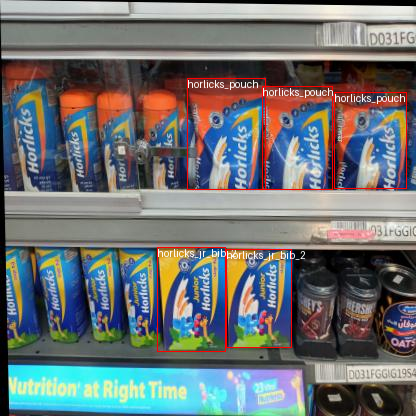

In [ ]:
from IPython.display import display

# Первый элемент в датасете
data_item = dataset_dict["train"][0]

# Изображение и аннотации
image = data_item["image"]
annotations = data_item["objects"]

# Создаем объект для рисования на изображении
draw = ImageDraw.Draw(image)

# Получаем категории из данных
categories = [cat['name'] for cat in data['categories']]

# Создаем словари для преобразования между ID и именами категорий
id2label = {cat['id']: cat['name'] for cat in data['categories']}
label2id = {v: k for k, v in id2label.items()}

# Рисуем bounding boxes для каждого объекта на изображении
for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    if max(box) > 1.0:
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        x1 = int(x * image.width)
        y1 = int(y * image.height)
        x2 = int((x + w) * image.width)
        y2 = int((y + h) * image.height)
    draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
    draw.text((x1, y1), id2label[class_idx], fill="white")

# Показываем изображение
display(image)

In [ ]:
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

c:\Users\Kreal\miniconda3\envs\ts\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# создаем объект преобразований для изображений
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [ ]:
# преобразуем аннотации
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# для создания одного батча - скомбинируем изображение и аннотацию
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Нужно отфильтровать данные, которые вызывают ошибки при комбинировании изображения и аннотации

In [ ]:
len(dataset_dict["train"])

1231

In [ ]:
tempdataset = dataset_dict.copy()
error_vals = []

# пример того, как осуществляется комбинирование изображения и аннотации
tempdataset["train"] = tempdataset["train"].with_transform(transform_aug_ann)
for i in range(1231):
    try:
      tempdataset["train"][i]
    except:
       error_vals.append(i)
error_vals


[18,
 42,
 80,
 81,
 84,
 89,
 90,
 100,
 106,
 108,
 124,
 128,
 137,
 148,
 150,
 174,
 202,
 206,
 209,
 217,
 226,
 230,
 232,
 234,
 245,
 256,
 263,
 276,
 280,
 292,
 297,
 303,
 315,
 324,
 338,
 346,
 362,
 377,
 389,
 394,
 409,
 413,
 416,
 431,
 450,
 459,
 481,
 502,
 516,
 517,
 520,
 521,
 525,
 533,
 552,
 554,
 564,
 578,
 583,
 595,
 597,
 610,
 618,
 629,
 634,
 643,
 650,
 657,
 660,
 661,
 667,
 668,
 674,
 681,
 687,
 697,
 702,
 708,
 715,
 723,
 727,
 730,
 736,
 737,
 738,
 756,
 762,
 779,
 780,
 789,
 794,
 817,
 834,
 836,
 844,
 854,
 859,
 864,
 874,
 882,
 896,
 898,
 910,
 921,
 923,
 924,
 937,
 940,
 944,
 947,
 960,
 998,
 1007,
 1017,
 1019,
 1029,
 1055,
 1060,
 1066,
 1070,
 1075,
 1080,
 1085,
 1089,
 1094,
 1095,
 1101,
 1116,
 1122,
 1123,
 1140,
 1144,
 1149,
 1152,
 1156,
 1158,
 1176,
 1186,
 1190,
 1214]

In [ ]:
print(f"Всего записей данных, вызвавших ошибки = {len(error_vals)}")

Всего записей данных, вызвавших ошибки = 140


In [ ]:
#Удаляем некорректные данные
ndataset = dataset_dict.copy()

keep = [i for i in range(len(ndataset["train"])) if i not in error_vals]
ndataset["train"] = ndataset["train"].select(keep)

SyntaxError: cannot assign to literal (1902062626.py, line 2)

Комбинируем изображения и аннотации

In [ ]:
ndataset["train"] = ndataset["train"].with_transform(transform_aug_ann)
ndataset["train"][15]

In [ ]:
# делаем всё красивее и удобнее
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [ ]:
# определяем модель (согласно названию в 'checkpoint')
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
# определяем гиперпараметры
training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_Market-v6i-coco",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [ ]:
!huggingface-cli login #выполнил из консоли, из блокнота не получилось

usage: huggingface-cli <command> [<args>]
huggingface-cli: error: unrecognized arguments: #выполнил из консоли, из блокнота не получилось


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ndataset["train"],
    tokenizer=image_processor,
)

trainer.train()

  0%|          | 0/1540 [00:00<?, ?it/s]

ValueError: Expected x_max for bbox (0.9471153846153846, 0.002403846153846154, 1.000389423076923, 0.14584615384615385, 49) to be in the range [0.0, 1.0], got 1.000389423076923.